Test for DLpipeline, using VGGs on cifar-10.

Project website: [https://github.com/HuadingLing/DLpipeline](https://github.com/HuadingLing/DLpipeline)

In [2]:
import torch
from torch import nn


cfgs = {
    'vgg_test': [16, 'M', 32, 'M', 64, 'M', 128, 'M', 512, 'M'],
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, cfg, vgg_name, in_channels=3, num_classes=10, Batch_norm=True, init_weights=True):
        super(VGG, self).__init__()
        self.name = vgg_name
        if Batch_norm:
            self.name += '_bn'
        self.features = self._make_layers(cfg[vgg_name], in_channels, Batch_norm)
        self.classifier = nn.Linear(512, num_classes)
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def _make_layers(self, cfg, in_channels , batch_norm):
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

In [3]:
from dlpipeline import DLpipeline, Executor, Progbar, Reporter, Saver, FileNameManager, output_to_score_fun
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

try:
    from torchsummary import summary
except:
    !pip install torchsummary
    from torchsummary import summary
    
''' 
try:
    from thop import profile, clever_format
except:
    !pip install thop
    from thop import profile, clever_format
'''

'''
def state_fun(pipeline):
    state = {'param': pipeline.model.state_dict(),
             'acc': pipeline.reporter.acc,
             'epoch': pipeline.epoch}
    return state
'''

def summary_fun(pipeline):
    from torchsummary import summary
    print('Model: %s' % pipeline.model_name)
    summary(pipeline.model, input_size=(3, 32, 32), device = pipeline.device.type)
    '''
    from thop import profile, clever_format
    input = torch.randn(1, 3, 32, 32)
    macs, params = profile(pipeline.model, inputs=(input, ))
    macs, params = clever_format([macs, params], "%.3f")
    print(macs, params)
    '''
    print('Optimizer:\n', pipeline.optimizer)
    
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return torch.device(device)


device = get_device()

batch_size = 256
save_dir = './checkpoint of vgg for cifar10/'
labels = [i for i in range(10)]

print('==> Preparing data ...')
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
])

trainset = CIFAR10('./cifar10', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = CIFAR10('./cifar10', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=250, shuffle=False, num_workers=2)


if device.type == 'cuda':
    #model = torch.nn.DataParallel(model)
    torch.backends.cudnn.benchmark = True
    
print('==> Bulding pipeline ...')
'''
# This can be use, but I prefer to use dict.
pipeline = DLpipeline(executor=Executor(),
                      progressbar=Progbar(dynamic = True),
                      reporter=Reporter(labels = labels, report_interval = 3, summary_fun = summary_fun),
                      saver=Saver(save_dir = save_dir,
                                  save_meta_file = True,
                                  save_ckpt_model = True, 
                                  save_val_model = True, 
                                  save_final_model = True,
                                  save_interval = 2, 
                                  test_model_use = 'final', 
                                  save_history = True),
                      file_name_manager=FileNameManager(),
                      device=device,
                      criterion=nn.CrossEntropyLoss(),
                      trainloader=trainloader,
                      #valloader=testloader,
                      testloader=testloader,
                     )
'''

basic_config = {'executor': Executor(),
                'progressbar': Progbar(dynamic = True),
                'reporter': Reporter(labels = labels, 
                                     need_confusion_matrix = True,
                                     output_to_score_fun = output_to_score_fun, 
                                     report_interval = 0,
                                     show_train_report = False,
                                     summary_fun = summary_fun),
                'saver': Saver(save_dir = save_dir,
                               save_meta_file = True,
                               save_ckpt_model = True, 
                               save_val_model = True, 
                               save_final_model = True,
                               save_final_optim = True,
                               save_interval = 5, 
                               test_model_use = 'final', 
                               save_history = True,
                               save_train_report = False,
                               save_test_report = True),
                'file_name_manager' : FileNameManager(),
                'device': device,
                'criterion' : nn.CrossEntropyLoss(),
                'trainloader': trainloader,
                'valloader': testloader,
                'testloader': testloader,
               }


pipeline = DLpipeline(**basic_config)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
==> Preparing data ...


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
==> Bulding pipeline ...


In [4]:
learning_rate = 0.05
weight_decay = 1e-3
momentum = 0.9

#print('==> Building model ...')
model = VGG(cfgs, 'vgg11', Batch_norm=False).to(device)
#summary(model, input_size=(3, 32, 32), device=device.type)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
pipeline.setup(model = model, model_name = model.name, optimizer = optimizer)



# Basic operation


Use this to create a new pipeline, it will create a new folder under *saver.save\_dir*. Then every thing will be saved in this folder (if enable save). The name of the created folder is controlled by FileNameManager, default to time+model_name.
```python
pipeline.create_pipeline()
```

Use this to create a new pipeline, it will create a new folder with its path as user specify. Then every thing will save in this folder (if enable save). If the folder exists, then it will load the satify file with the maximum epoch. If not satify file, it will start a new training branch (two different pipeline share the same folder, try to avoid this because file cover will happen)
```python
pipeline.create_pipeline(save_dir + 'vgg_test/')
```

Use this to load an exist pipeline (mainly model+optim+hist+last\_epoch).
```python
pipeline.load('pipeline', save_dir + 'vgg_test/20200923_225741 vgg_test epoch_18 val.pt')
```

Use this to load an exist pipeline, without specify file name, let the program to find the satify file with the maximum epoch. If not satify file, it will start a new training branch (two different pipelines share the same folder, try to avoid this because file cover will happen).
```python
pipeline.load('pipeline', save_dir + 'vgg_test/')
```

Use this to load a exist history, this history is not mean to serve as continue training. If you want to continue training, load pipeline or model instead of history.
```python
pipeline.load('history', save_dir + 'vgg_test/history 20200923_225937 vgg_test epoch_20.hist')
```

Use this to report the result (train and test).
```python
pipeline.report()
```

Use this to report the train result.
```python
pipeline.report(modes = ['train', 'val'])
```

Use this to report the test result.
```python
pipeline.report(modes = 'test') 
```

The state of the pipeline (or *pipeline.start\_epoch*) only change when successfully load or create 'pipeline' using:

```python
pipeline.load('pipeline', ...)
# or
pipeline.create_pipeline(...)
```

More info, can be explore by using *\_\_dict\_\_*

```python
pipeline.__dict__
pipeline.saver.__dict__
pipeline.reporter.__dict__

history = pipeline.reporter.history
history.keys()
```

In [6]:
pipeline.create_pipeline()  # create a new pipeline
pipeline.summary()

Create new folder {checkpoint of vgg for cifar10/20200924_163848 vgg11}
Model: vgg11
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-

Saving meta ... Meta has been save to {checkpoint of vgg for cifar10/20200924_163848 vgg11/meta.json}
Train on 50000 samples, validate on 10000 samples. Start training ...
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch                                                                          Time used                 ETA         Loss     Acc                     ValLoss  ValAcc                  Time used                 ETA     
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 5/20 [============================================================] 196/196   12s452ms (15ms/step)      0ms         0.6697   0.7657 (38287/50000)    0.7338   0.7489 (7489/10

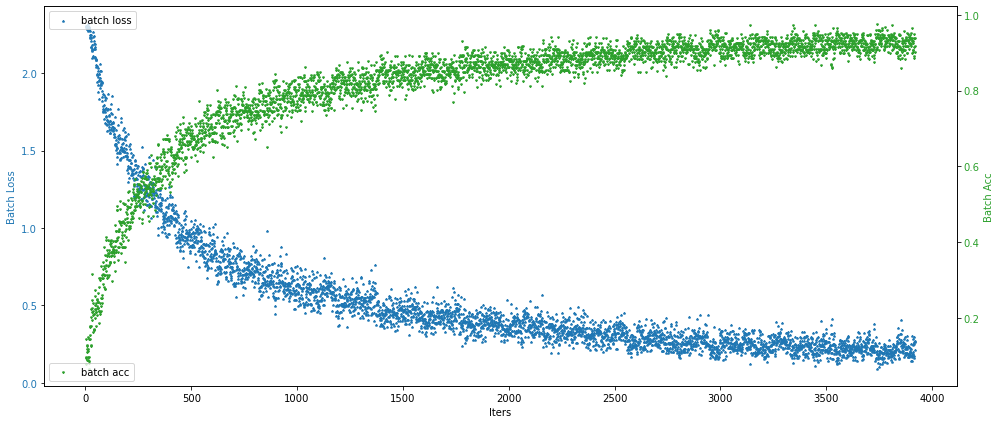

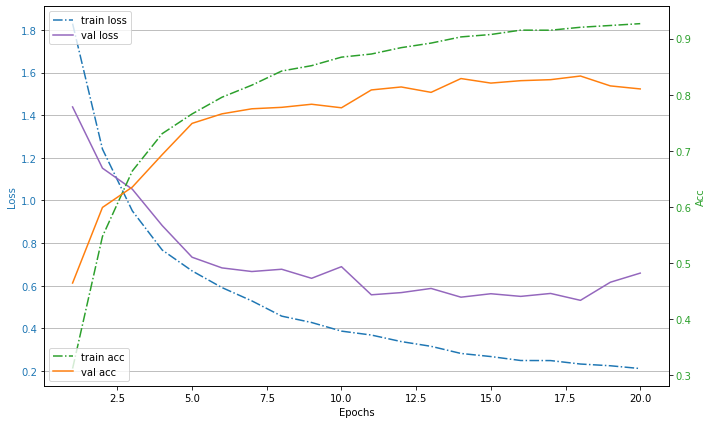

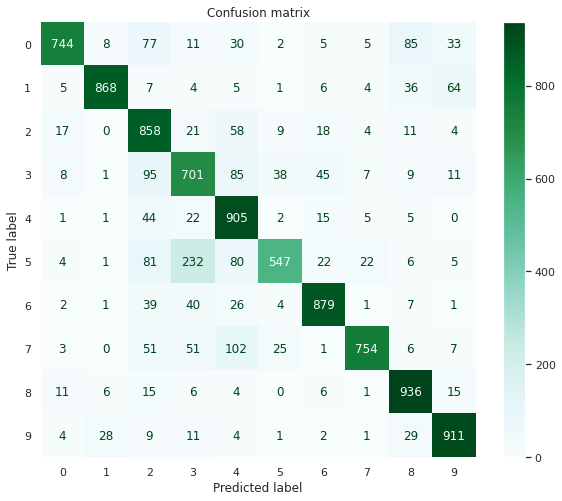

Confusion matrix:
[[744   8  77  11  30   2   5   5  85  33]
 [  5 868   7   4   5   1   6   4  36  64]
 [ 17   0 858  21  58   9  18   4  11   4]
 [  8   1  95 701  85  38  45   7   9  11]
 [  1   1  44  22 905   2  15   5   5   0]
 [  4   1  81 232  80 547  22  22   6   5]
 [  2   1  39  40  26   4 879   1   7   1]
 [  3   0  51  51 102  25   1 754   6   7]
 [ 11   6  15   6   4   0   6   1 936  15]
 [  4  28   9  11   4   1   2   1  29 911]]


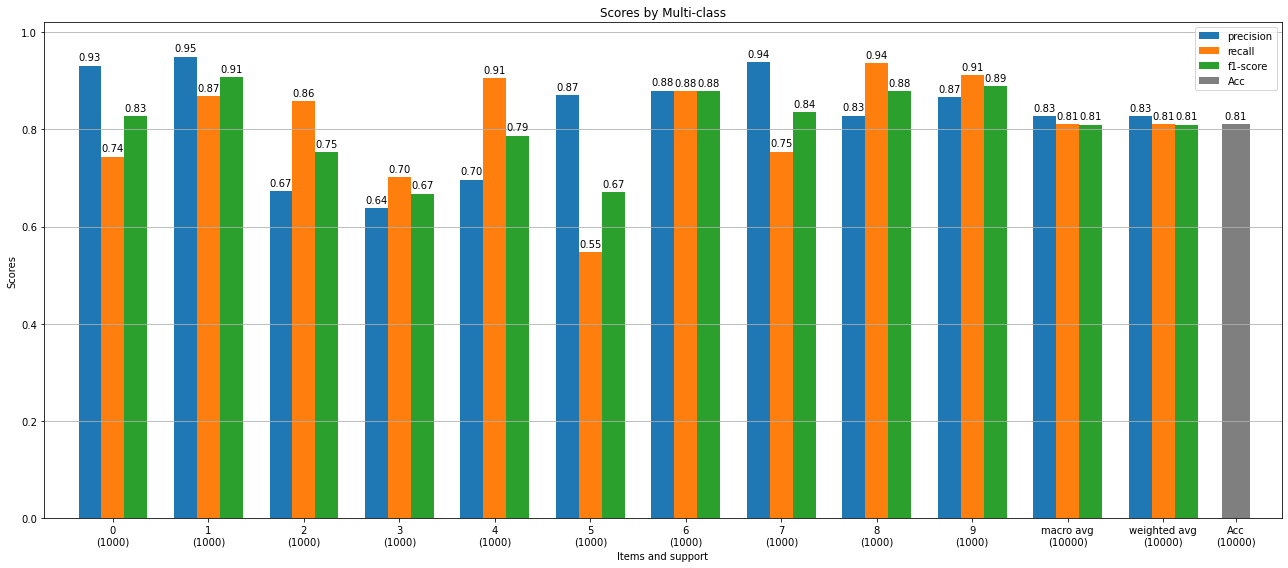


Classification report:

              precision    recall  f1-score   support

           0     0.9312    0.7440    0.8271      1000
           1     0.9497    0.8680    0.9070      1000
           2     0.6724    0.8580    0.7540      1000
           3     0.6379    0.7010    0.6679      1000
           4     0.6967    0.9050    0.7873      1000
           5     0.8696    0.5470    0.6716      1000
           6     0.8799    0.8790    0.8794      1000
           7     0.9378    0.7540    0.8359      1000
           8     0.8283    0.9360    0.8789      1000
           9     0.8668    0.9110    0.8883      1000

    accuracy                         0.8103     10000
   macro avg     0.8270    0.8103    0.8097     10000
weighted avg     0.8270    0.8103    0.8097     10000


One-vs-One ROC AUC scores:
0.981575 (macro),
0.981575 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.981575 (macro),
0.981575 (weighted by prevalence)


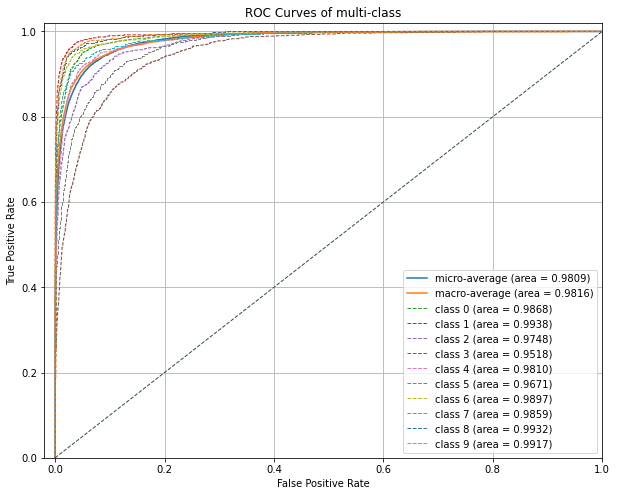

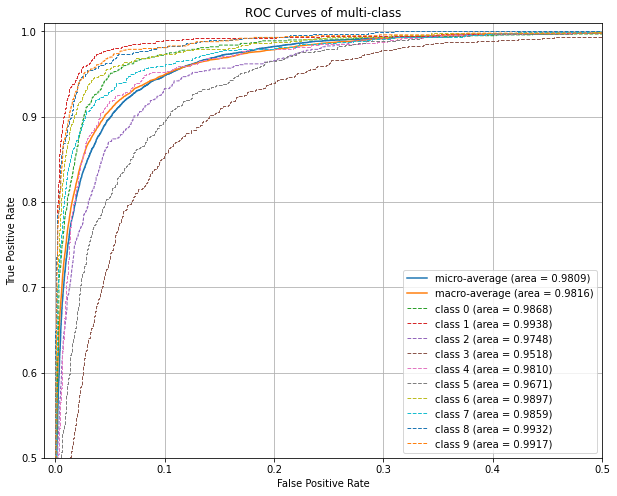

In [7]:
pipeline(end_epoch = 20)  # train 20 epoch, from epoch=1 to epoch=20

Saving meta ... Meta has been save to {checkpoint of vgg for cifar10/20200924_163848 vgg11/meta.json}
Train on 50000 samples, validate on 10000 samples. Start training ...
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch                                                                          Time used                 ETA         Loss     Acc                     ValLoss  ValAcc                  Time used                 ETA     
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
25/40 [============================================================] 196/196   14s27ms (15ms/step)       0ms         0.1800   0.9382 (46908/50000)    0.6108   0.8246 (8246/10

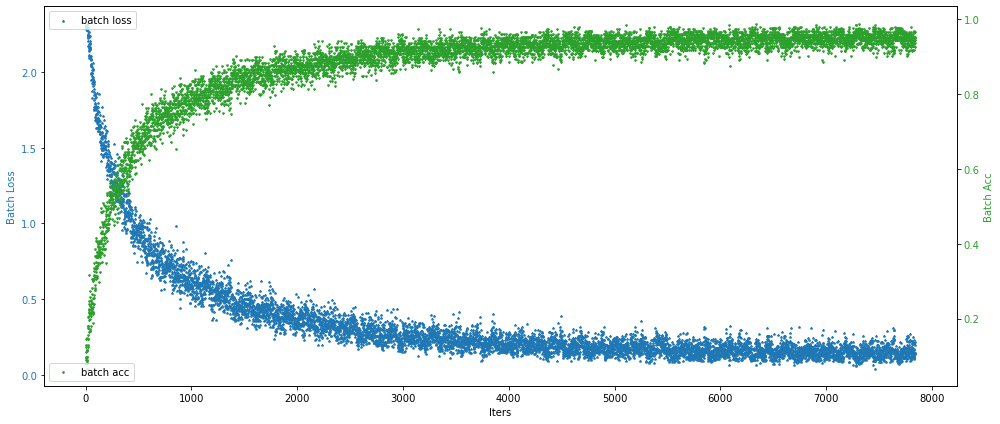

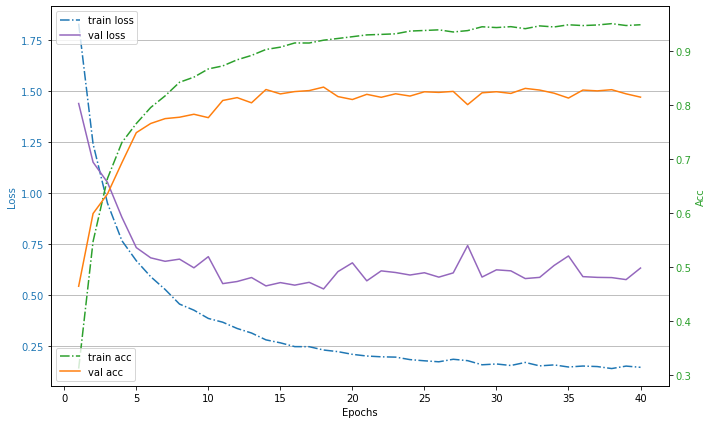

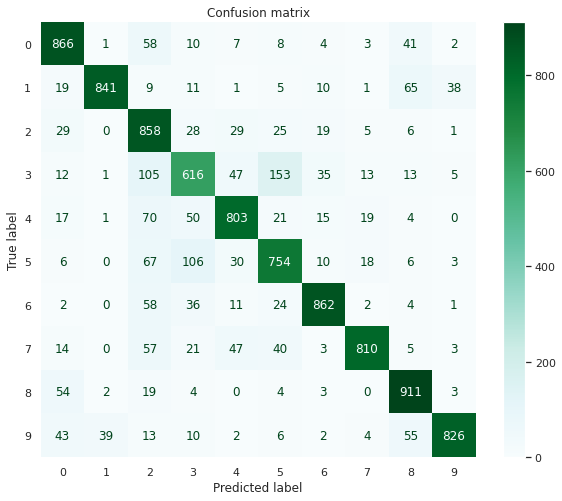

Confusion matrix:
[[866   1  58  10   7   8   4   3  41   2]
 [ 19 841   9  11   1   5  10   1  65  38]
 [ 29   0 858  28  29  25  19   5   6   1]
 [ 12   1 105 616  47 153  35  13  13   5]
 [ 17   1  70  50 803  21  15  19   4   0]
 [  6   0  67 106  30 754  10  18   6   3]
 [  2   0  58  36  11  24 862   2   4   1]
 [ 14   0  57  21  47  40   3 810   5   3]
 [ 54   2  19   4   0   4   3   0 911   3]
 [ 43  39  13  10   2   6   2   4  55 826]]


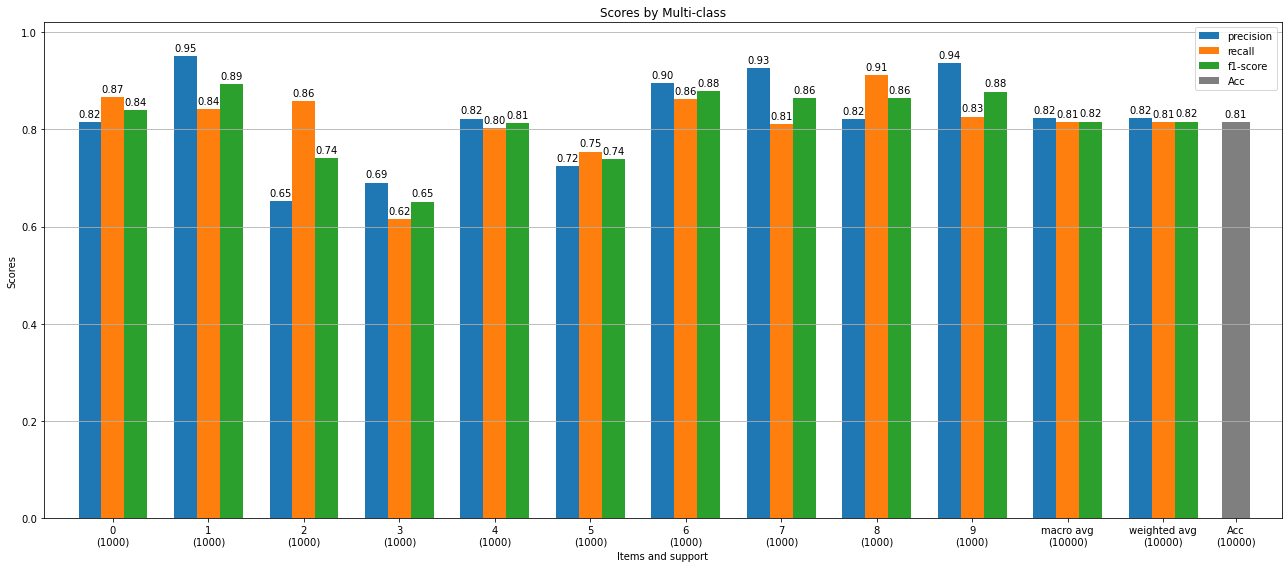


Classification report:

              precision    recall  f1-score   support

           0     0.8154    0.8660    0.8400      1000
           1     0.9503    0.8410    0.8923      1000
           2     0.6530    0.8580    0.7416      1000
           3     0.6906    0.6160    0.6512      1000
           4     0.8219    0.8030    0.8123      1000
           5     0.7250    0.7540    0.7392      1000
           6     0.8951    0.8620    0.8782      1000
           7     0.9257    0.8100    0.8640      1000
           8     0.8207    0.9110    0.8635      1000
           9     0.9365    0.8260    0.8778      1000

    accuracy                         0.8147     10000
   macro avg     0.8234    0.8147    0.8160     10000
weighted avg     0.8234    0.8147    0.8160     10000


One-vs-One ROC AUC scores:
0.981526 (macro),
0.981526 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.981526 (macro),
0.981526 (weighted by prevalence)


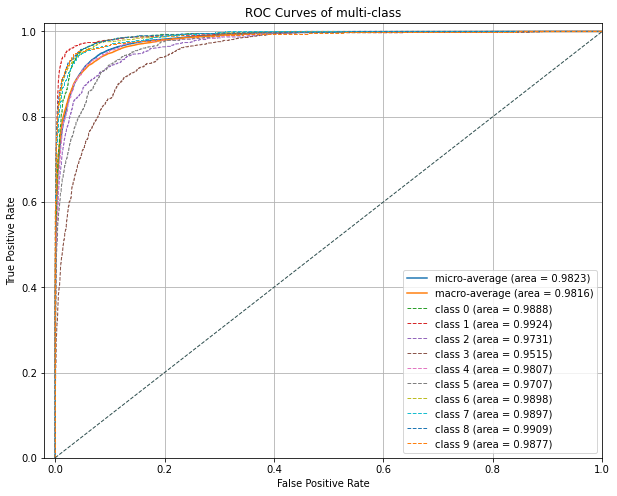

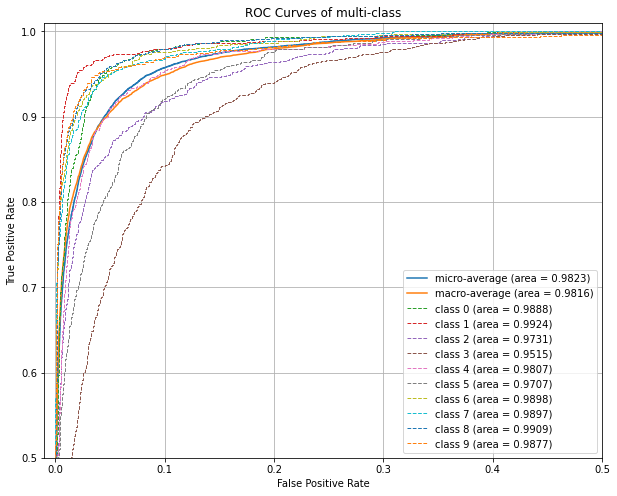

In [8]:
pipeline(40)  # continue training, from epoch=21 to epoch=40

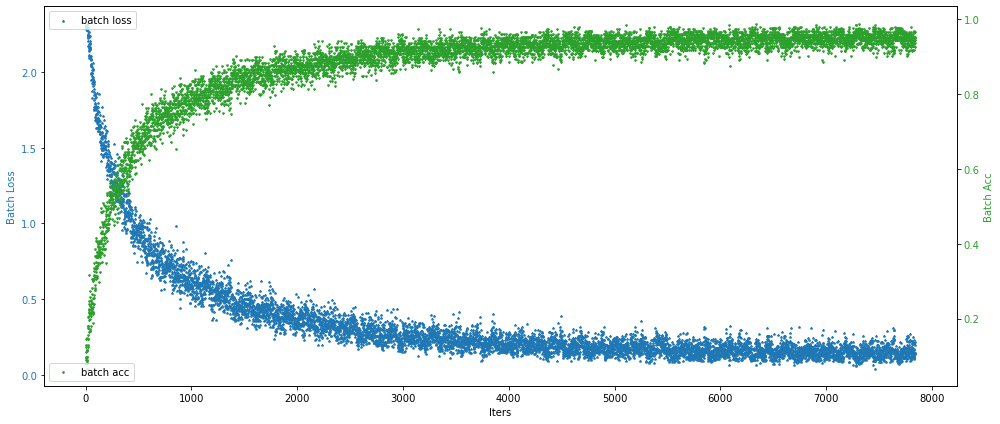

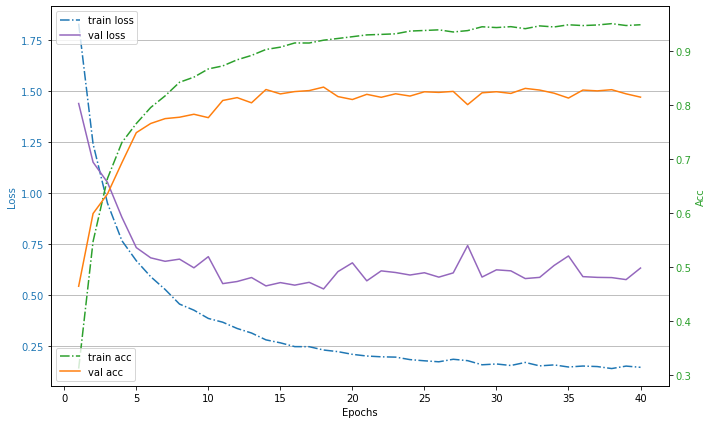

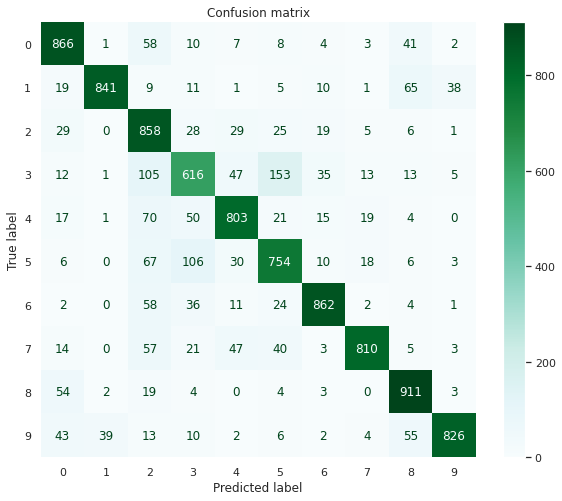

Confusion matrix:
[[866   1  58  10   7   8   4   3  41   2]
 [ 19 841   9  11   1   5  10   1  65  38]
 [ 29   0 858  28  29  25  19   5   6   1]
 [ 12   1 105 616  47 153  35  13  13   5]
 [ 17   1  70  50 803  21  15  19   4   0]
 [  6   0  67 106  30 754  10  18   6   3]
 [  2   0  58  36  11  24 862   2   4   1]
 [ 14   0  57  21  47  40   3 810   5   3]
 [ 54   2  19   4   0   4   3   0 911   3]
 [ 43  39  13  10   2   6   2   4  55 826]]


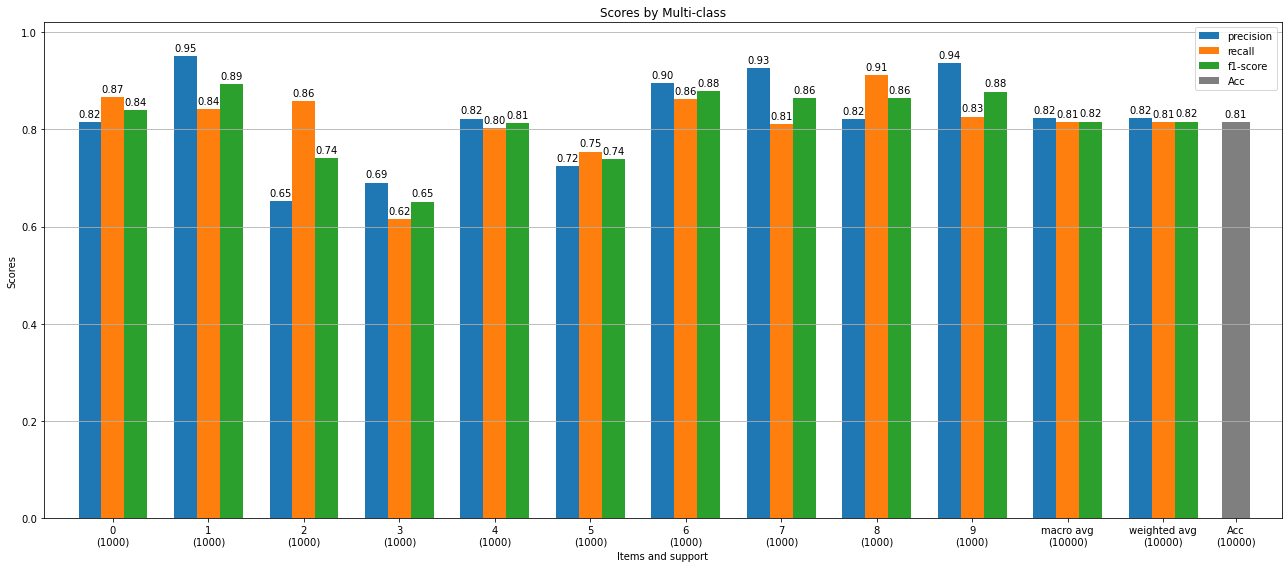


Classification report:

              precision    recall  f1-score   support

           0     0.8154    0.8660    0.8400      1000
           1     0.9503    0.8410    0.8923      1000
           2     0.6530    0.8580    0.7416      1000
           3     0.6906    0.6160    0.6512      1000
           4     0.8219    0.8030    0.8123      1000
           5     0.7250    0.7540    0.7392      1000
           6     0.8951    0.8620    0.8782      1000
           7     0.9257    0.8100    0.8640      1000
           8     0.8207    0.9110    0.8635      1000
           9     0.9365    0.8260    0.8778      1000

    accuracy                         0.8147     10000
   macro avg     0.8234    0.8147    0.8160     10000
weighted avg     0.8234    0.8147    0.8160     10000


One-vs-One ROC AUC scores:
0.981526 (macro),
0.981526 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.981526 (macro),
0.981526 (weighted by prevalence)


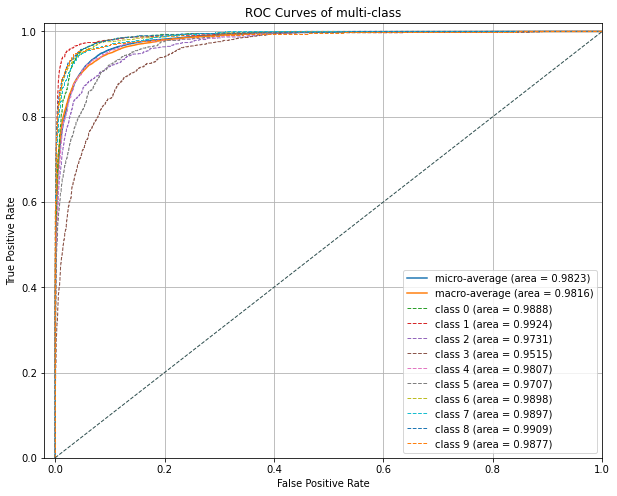

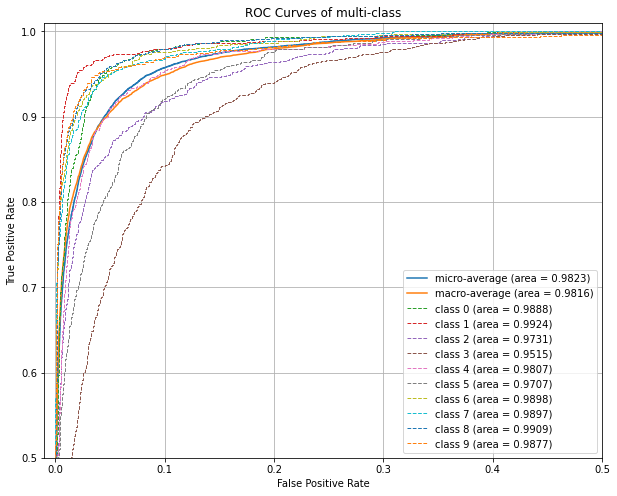

In [9]:
# report the result
pipeline.report()

In [10]:
# change model (reset optimizer) and pipeline
model = VGG(cfgs, 'vgg11', Batch_norm=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
pipeline.setup(model = model, model_name = model.name, optimizer = optimizer)

# Now we specify the folder, and create a new pipeline
pipeline.create_pipeline(save_dir + 'vgg_test/')
pipeline.summary()

Create new folder {checkpoint of vgg for cifar10/vgg_test}
Model: vgg11_bn
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13        

Saving meta ... Meta has been save to {checkpoint of vgg for cifar10/vgg_test/meta.json}
Train on 50000 samples, validate on 10000 samples. Start training ...
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch                                                                          Time used                 ETA         Loss     Acc                     ValLoss  ValAcc                  Time used                 ETA     
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 5/20 [============================================================] 196/196   15s189ms (16ms/step)      0ms         0.6042   0.7876 (39381/50000)    0.7627   0.7380 (7380/10000)     2s10

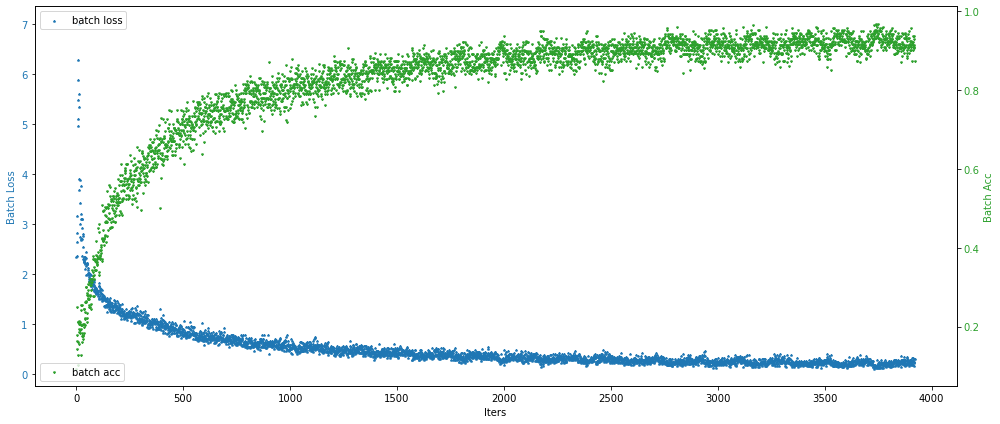

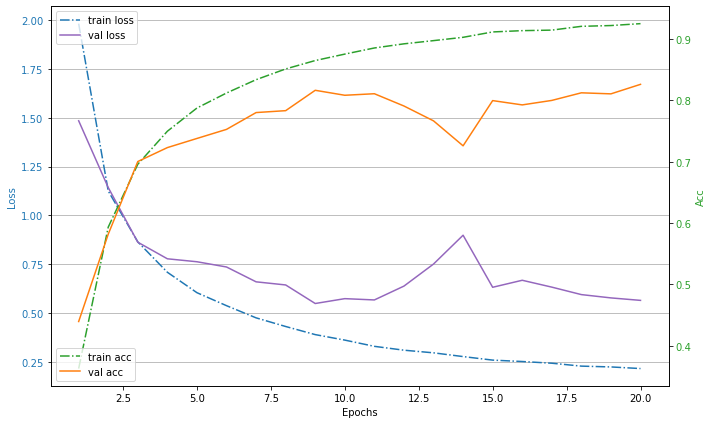

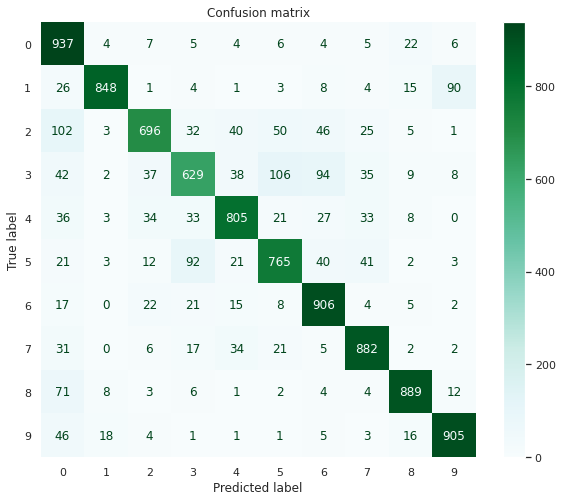

Confusion matrix:
[[937   4   7   5   4   6   4   5  22   6]
 [ 26 848   1   4   1   3   8   4  15  90]
 [102   3 696  32  40  50  46  25   5   1]
 [ 42   2  37 629  38 106  94  35   9   8]
 [ 36   3  34  33 805  21  27  33   8   0]
 [ 21   3  12  92  21 765  40  41   2   3]
 [ 17   0  22  21  15   8 906   4   5   2]
 [ 31   0   6  17  34  21   5 882   2   2]
 [ 71   8   3   6   1   2   4   4 889  12]
 [ 46  18   4   1   1   1   5   3  16 905]]


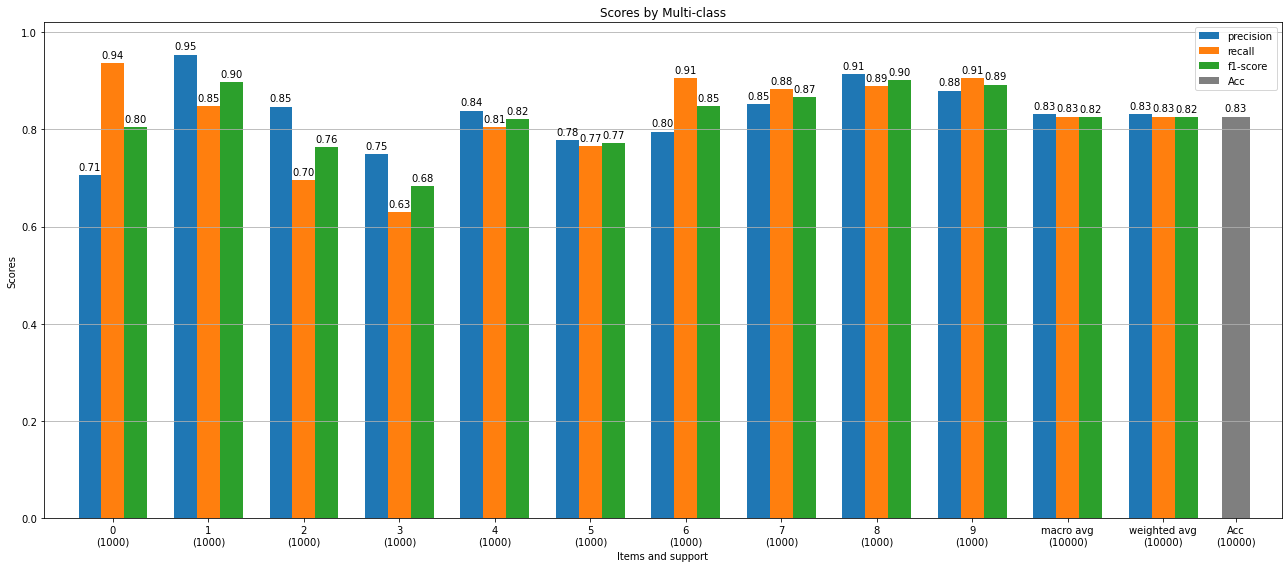


Classification report:

              precision    recall  f1-score   support

           0     0.7050    0.9370    0.8046      1000
           1     0.9539    0.8480    0.8978      1000
           2     0.8467    0.6960    0.7640      1000
           3     0.7488    0.6290    0.6837      1000
           4     0.8385    0.8050    0.8214      1000
           5     0.7782    0.7650    0.7716      1000
           6     0.7954    0.9060    0.8471      1000
           7     0.8514    0.8820    0.8664      1000
           8     0.9137    0.8890    0.9012      1000
           9     0.8795    0.9050    0.8921      1000

    accuracy                         0.8262     10000
   macro avg     0.8311    0.8262    0.8250     10000
weighted avg     0.8311    0.8262    0.8250     10000


One-vs-One ROC AUC scores:
0.983239 (macro),
0.983239 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.983239 (macro),
0.983239 (weighted by prevalence)


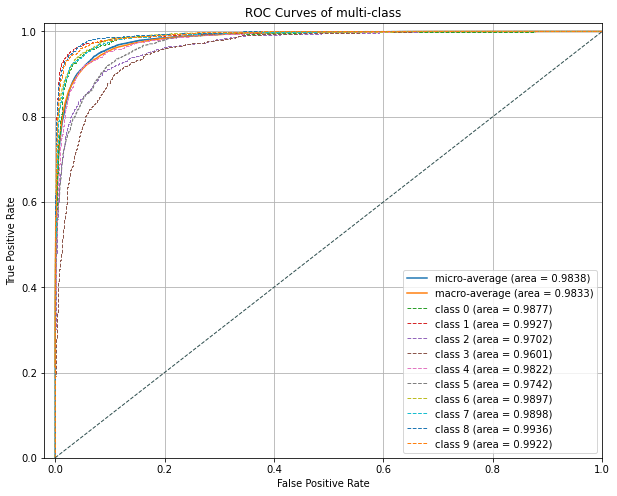

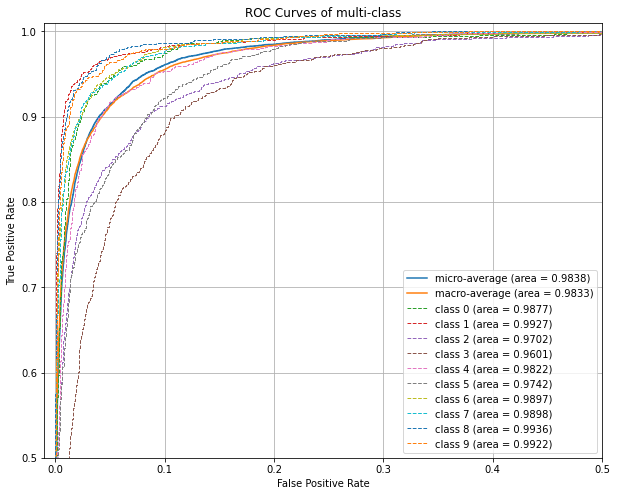

In [11]:
pipeline(20)  # train 20 epoch, from epoch=1 to epoch=20

In [12]:
# change model (reset optimizer) and pipeline
model = VGG(cfgs, 'vgg11', Batch_norm=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
pipeline.setup(model = model, model_name = model.name, optimizer = optimizer)

# and we load the previous pipeline
pipeline.load('pipeline', save_dir + 'vgg_test/')
pipeline.summary()

Processing folder ...
Checking file {checkpoint of vgg for cifar10/vgg_test/20200924_165450 vgg11_bn epoch_20 final_val.pt} ...
Load history successfully.
Load model successfully.
Load optimizer successfully.
From epoch 20 by ckpt file {checkpoint of vgg for cifar10/vgg_test/20200924_165450 vgg11_bn epoch_20 final_val.pt}
Model: vgg11_bn
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-

Saving meta ... Meta has been save to {checkpoint of vgg for cifar10/vgg_test/meta.json}
Train on 50000 samples, validate on 10000 samples. Start training ...
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch                                                                          Time used                 ETA         Loss     Acc                     ValLoss  ValAcc                  Time used                 ETA     
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
25/50 [============================================================] 196/196   16s206ms (16ms/step)      0ms         0.1859   0.9355 (46777/50000)    0.7565   0.7872 (7872/10000)     2s32

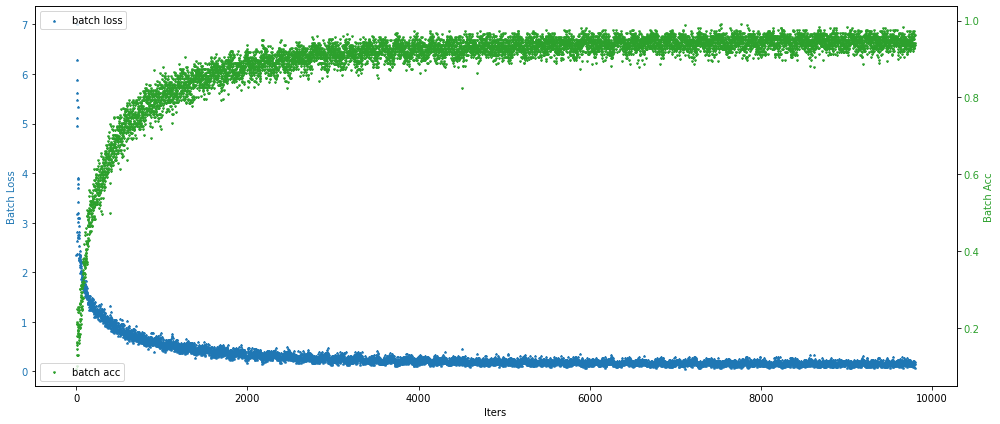

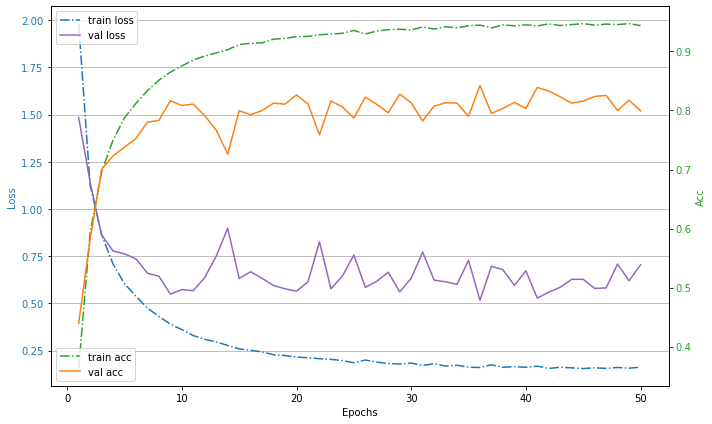

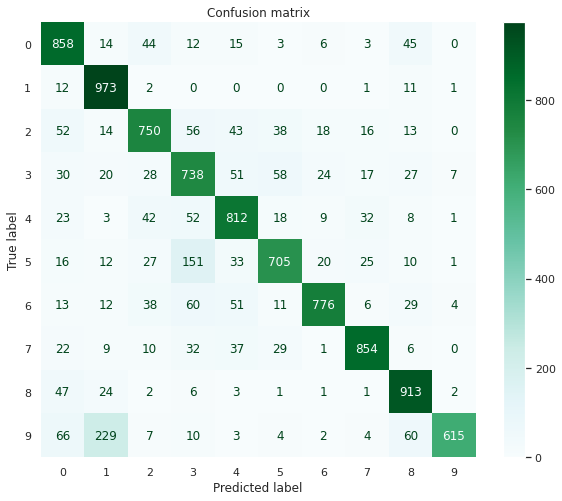

Confusion matrix:
[[858  14  44  12  15   3   6   3  45   0]
 [ 12 973   2   0   0   0   0   1  11   1]
 [ 52  14 750  56  43  38  18  16  13   0]
 [ 30  20  28 738  51  58  24  17  27   7]
 [ 23   3  42  52 812  18   9  32   8   1]
 [ 16  12  27 151  33 705  20  25  10   1]
 [ 13  12  38  60  51  11 776   6  29   4]
 [ 22   9  10  32  37  29   1 854   6   0]
 [ 47  24   2   6   3   1   1   1 913   2]
 [ 66 229   7  10   3   4   2   4  60 615]]


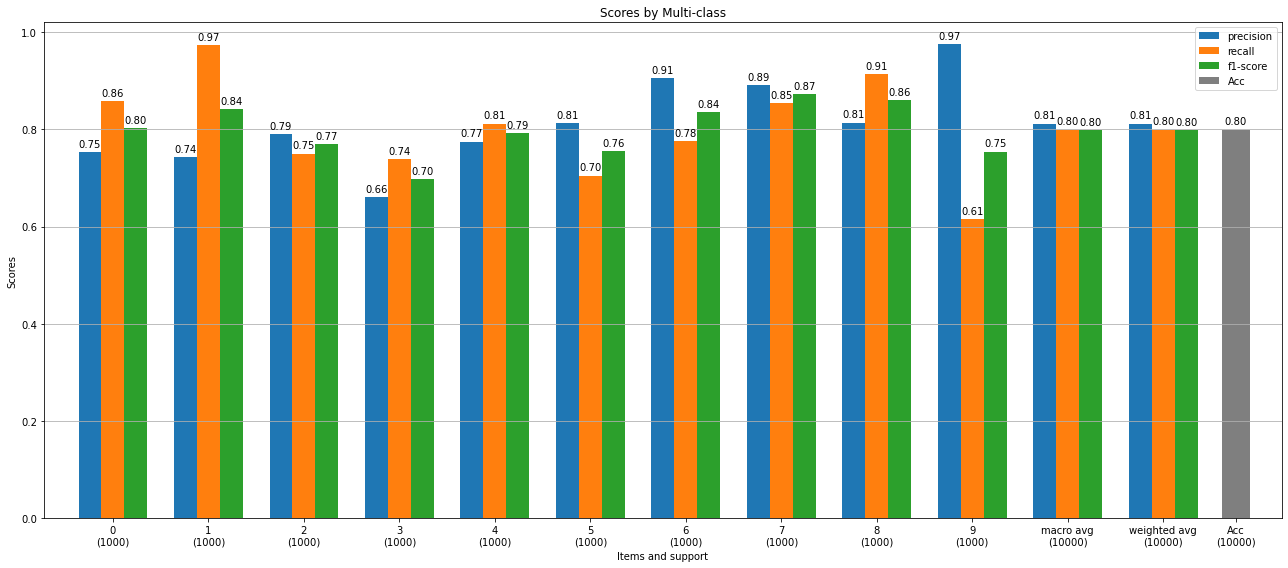


Classification report:

              precision    recall  f1-score   support

           0     0.7533    0.8580    0.8022      1000
           1     0.7427    0.9730    0.8424      1000
           2     0.7895    0.7500    0.7692      1000
           3     0.6607    0.7380    0.6972      1000
           4     0.7748    0.8120    0.7930      1000
           5     0.8131    0.7050    0.7552      1000
           6     0.9055    0.7760    0.8358      1000
           7     0.8905    0.8540    0.8719      1000
           8     0.8137    0.9130    0.8605      1000
           9     0.9746    0.6150    0.7541      1000

    accuracy                         0.7994     10000
   macro avg     0.8119    0.7994    0.7982     10000
weighted avg     0.8119    0.7994    0.7982     10000


One-vs-One ROC AUC scores:
0.979318 (macro),
0.979318 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.979318 (macro),
0.979318 (weighted by prevalence)


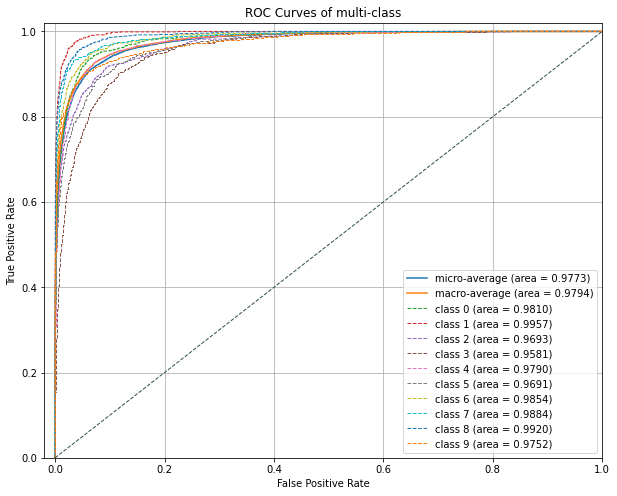

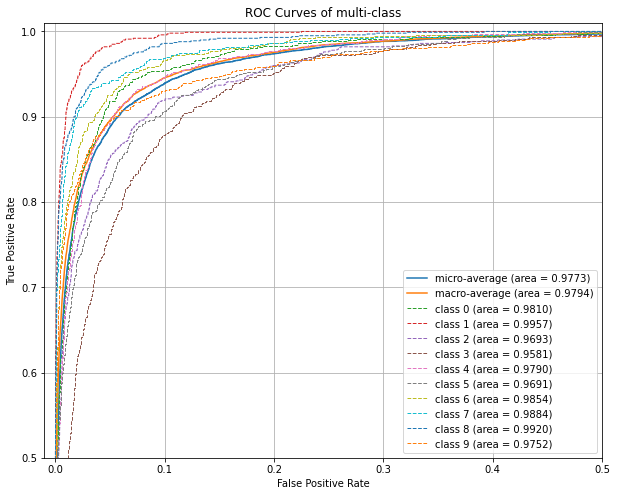

In [13]:
# continue training
pipeline(50)  # train 30 epoch, from epoch=21 to epoch=50

Load history successfully.


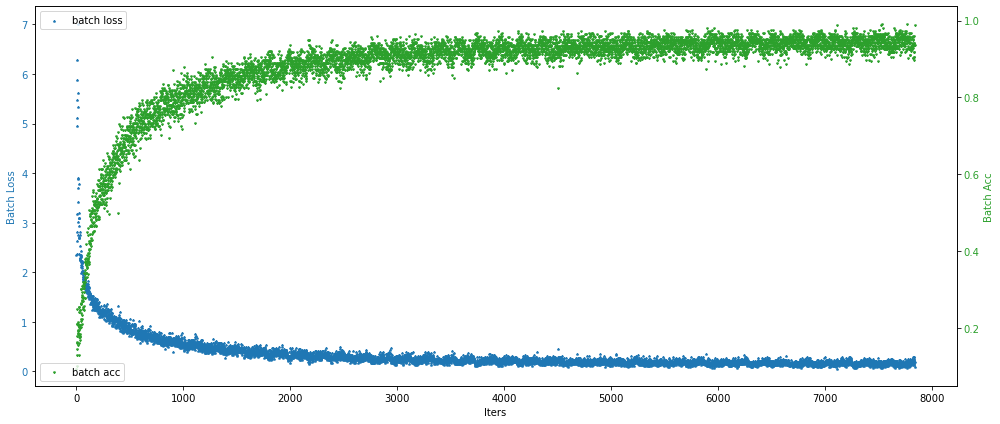

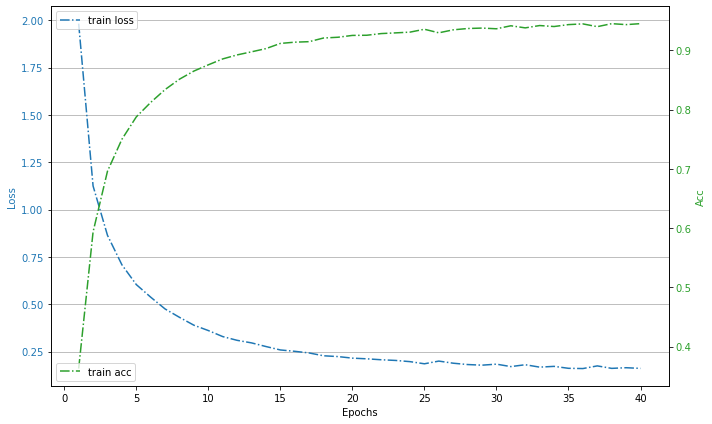

In [14]:
import os
import re

# load history in epoch 40 (from a model file)
files = os.listdir(save_dir + 'vgg_test/')
for file in files:
    e = re.search("epoch_\d+", file)
    if e and int(e.group()[6:]) == 40:
        break

pipeline.load('history', save_dir + 'vgg_test/' + file)

# report the result, but only report train result 
# becansue we don't have test result in this file
pipeline.report(modes = 'train')

Load history successfully.


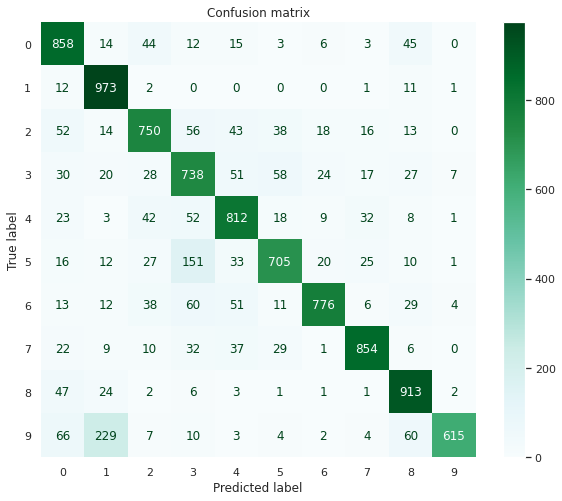

Confusion matrix:
[[858  14  44  12  15   3   6   3  45   0]
 [ 12 973   2   0   0   0   0   1  11   1]
 [ 52  14 750  56  43  38  18  16  13   0]
 [ 30  20  28 738  51  58  24  17  27   7]
 [ 23   3  42  52 812  18   9  32   8   1]
 [ 16  12  27 151  33 705  20  25  10   1]
 [ 13  12  38  60  51  11 776   6  29   4]
 [ 22   9  10  32  37  29   1 854   6   0]
 [ 47  24   2   6   3   1   1   1 913   2]
 [ 66 229   7  10   3   4   2   4  60 615]]


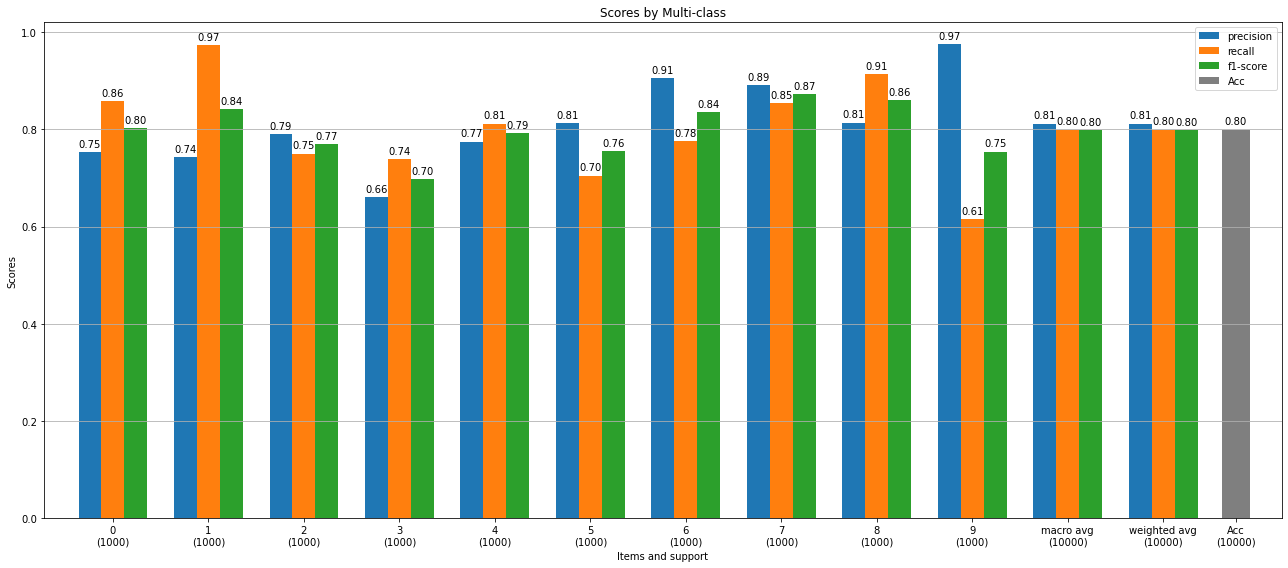


Classification report:

              precision    recall  f1-score   support

           0     0.7533    0.8580    0.8022      1000
           1     0.7427    0.9730    0.8424      1000
           2     0.7895    0.7500    0.7692      1000
           3     0.6607    0.7380    0.6972      1000
           4     0.7748    0.8120    0.7930      1000
           5     0.8131    0.7050    0.7552      1000
           6     0.9055    0.7760    0.8358      1000
           7     0.8905    0.8540    0.8719      1000
           8     0.8137    0.9130    0.8605      1000
           9     0.9746    0.6150    0.7541      1000

    accuracy                         0.7994     10000
   macro avg     0.8119    0.7994    0.7982     10000
weighted avg     0.8119    0.7994    0.7982     10000


One-vs-One ROC AUC scores:
0.979318 (macro),
0.979318 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.979318 (macro),
0.979318 (weighted by prevalence)


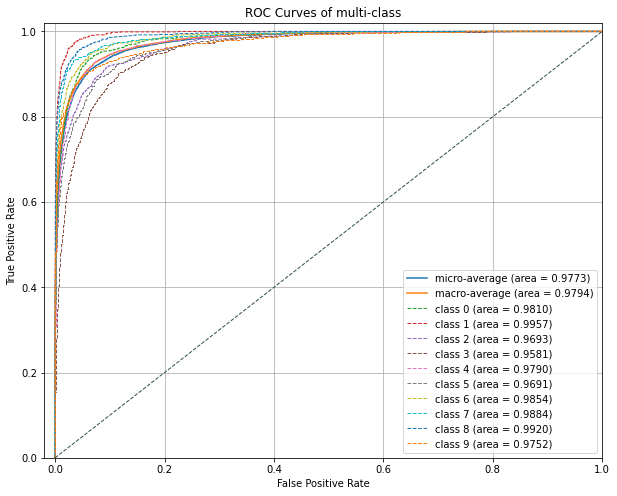

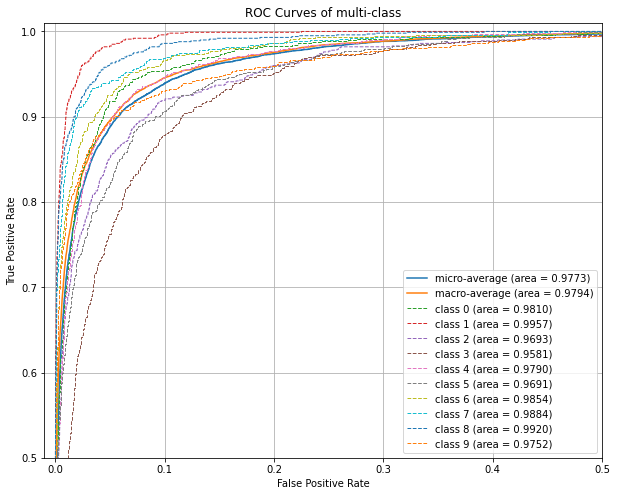

In [15]:
# load history in epoch 50
files = os.listdir(save_dir + 'vgg_test/')
for file in files:
    h = file[:7] == 'history'
    e = re.search("epoch_\d+", file)
    if h and e and int(e.group()[6:]) == 50:
        break

pipeline.load('history', save_dir + 'vgg_test/' + file)

# report the result, but only report test result
pipeline.report(modes = 'test')

Processing file ...
Load history successfully.
Load model successfully.
Load optimizer successfully.
From epoch 15 by ckpt file {checkpoint of vgg for cifar10/vgg_test/20200924_165331 vgg11_bn epoch_15 ckpt.pt}
Saving meta ... Meta has been save to {checkpoint of vgg for cifar10/vgg_test/meta.json}
Train on 50000 samples, validate on 10000 samples. Start training ...
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch                                                                          Time used                 ETA         Loss     Acc                     ValLoss  ValAcc                  Time used                 ETA     
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

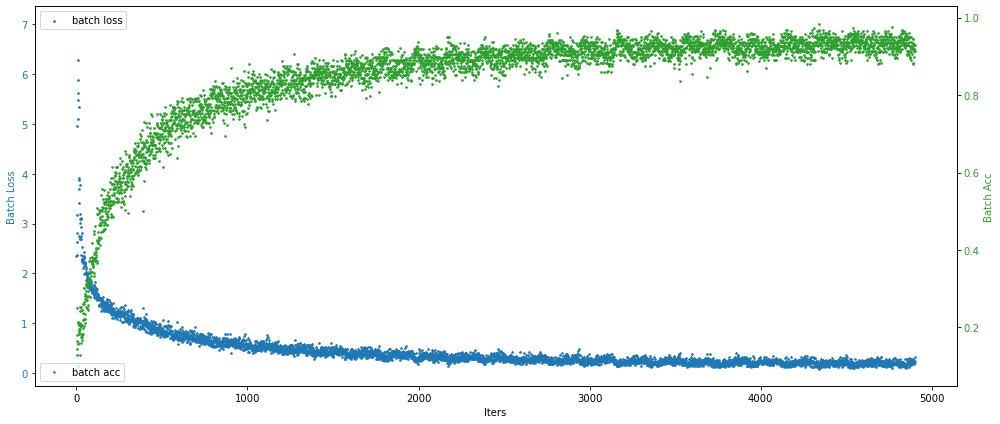

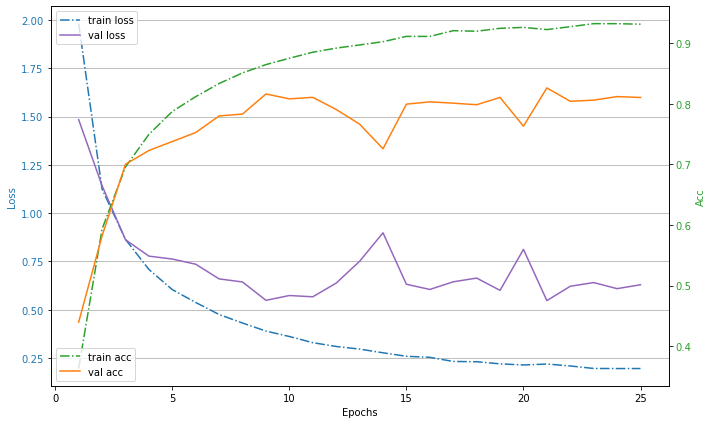

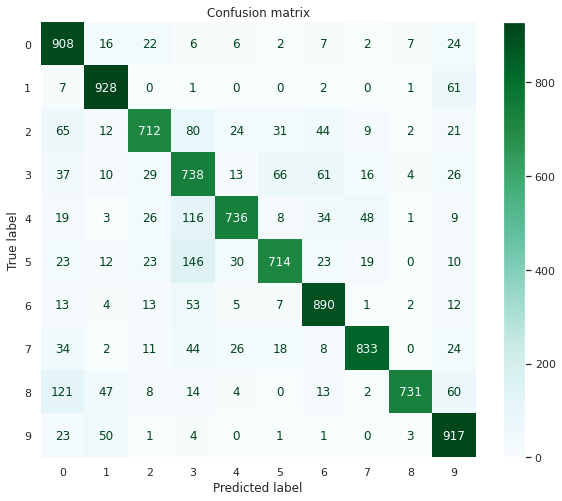

Confusion matrix:
[[908  16  22   6   6   2   7   2   7  24]
 [  7 928   0   1   0   0   2   0   1  61]
 [ 65  12 712  80  24  31  44   9   2  21]
 [ 37  10  29 738  13  66  61  16   4  26]
 [ 19   3  26 116 736   8  34  48   1   9]
 [ 23  12  23 146  30 714  23  19   0  10]
 [ 13   4  13  53   5   7 890   1   2  12]
 [ 34   2  11  44  26  18   8 833   0  24]
 [121  47   8  14   4   0  13   2 731  60]
 [ 23  50   1   4   0   1   1   0   3 917]]


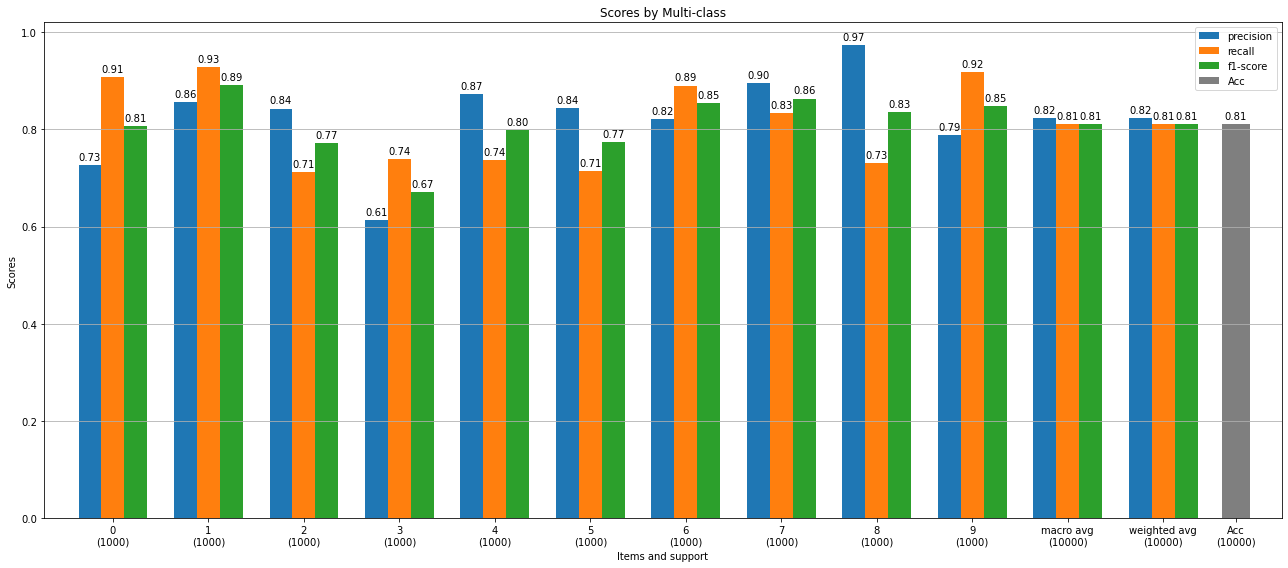


Classification report:

              precision    recall  f1-score   support

           0     0.7264    0.9080    0.8071      1000
           1     0.8561    0.9280    0.8906      1000
           2     0.8426    0.7120    0.7718      1000
           3     0.6140    0.7380    0.6703      1000
           4     0.8720    0.7360    0.7983      1000
           5     0.8430    0.7140    0.7731      1000
           6     0.8218    0.8900    0.8545      1000
           7     0.8957    0.8330    0.8632      1000
           8     0.9734    0.7310    0.8350      1000
           9     0.7878    0.9170    0.8475      1000

    accuracy                         0.8107     10000
   macro avg     0.8233    0.8107    0.8111     10000
weighted avg     0.8233    0.8107    0.8111     10000


One-vs-One ROC AUC scores:
0.981281 (macro),
0.981281 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.981281 (macro),
0.981281 (weighted by prevalence)


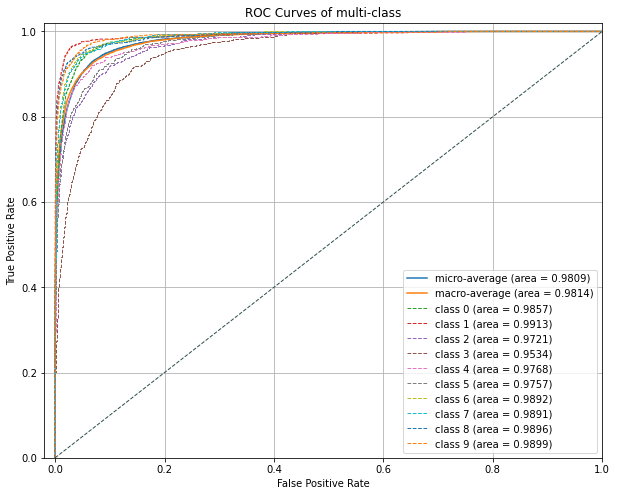

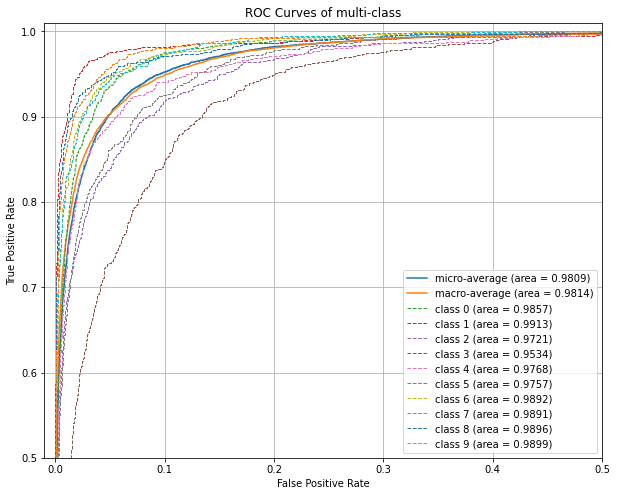

In [16]:
# load pipeline in epoch 15 (from a model file)
files = os.listdir(save_dir + 'vgg_test/')
for file in files:
    e = re.search("epoch_\d+", file)
    if e and int(e.group()[6:]) == 15:
        break
pipeline.load('pipeline', save_dir + 'vgg_test/' + file)

# continue training, from epoch=16 to epoch=25
# this is a new training branch. The previous one ends at epoch=50
pipeline(25)